In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import menpo.io as mio
from menpo.landmark import labeller, left_ventricle_34,left_ventricle_34_trimesh,left_ventricle_34_trimesh1
from menpofit.aam import HolisticAAM,PatchAAM
from menpo.transform import ThinPlateSplines
from menpo.feature import *
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional
from menpofit.fitter import noisy_shape_from_bounding_box
from menpofit.visualize import plot_cumulative_error_distribution
from menpowidgets import *
from menpodetect import load_dlib_left_ventricle_detector
from menpo.io import export_pickle,import_pickle
from pathlib import Path

# method to load a database
def load_database(path_to_images, crop_percentage,max_diagonal=400, max_images=None):
    images = []
    # load landmarked images
    for i in mio.import_images(path_to_images, max_images=max_images, verbose=True):
           
        # convert it to grayscale if needed
        if i.n_channels == 3:
            i = i.as_greyscale(mode='luminosity')
        # crop image
        i = i.crop_to_landmarks_proportion(crop_percentage)
        
        d = i.diagonal()
        if d > max_diagonal:
            i = i.rescale(float(max_diagonal) / d)
        # define a TriMesh which will be useful for Piecewise Affine Warp of HolisticAAM
        
        labeller(i, 'PTS', left_ventricle_34)#lv_34_trimesh
        labeller(i, 'PTS', left_ventricle_34_trimesh1)
        labeller(i, 'PTS', left_ventricle_34_trimesh)
        
        # append it to the list
        images.append(i)
    return images

crop_percentage = 0.5
path_to_lfpw = Path('K:/datasets/lv_pts_216/')
train_images = load_database(path_to_lfpw/ 'trainset',crop_percentage)
test_images = load_database(path_to_lfpw/ 'testset' , crop_percentage,max_images=5)

@imgfeature
def fast_dsift2(image):
    if image.n_channels == 3:
        image = image.as_greyscale(mode='average')
    return fast_dsift(image)
##build Holistic AAM

def norm_int(image):
    norm_image = image.copy()
    norm_image.normalize_std()
    return norm_image


Found 212 assets, index the returned LazyList to import.
Found 5 assets, index the returned LazyList to import.


In [9]:
#visualize_images(training_images)

# Unified HDMs and PBDMs

In [5]:
import sys
sys.path.insert(0,'I:/menpo/Unified' )
import numpy as np
from menpo.feature import no_op, fast_dsift
from alabortcvpr2015.unified import PartsUnifiedBuilder
group= "lv_34"
offsets = np.meshgrid(range(-0, 1, 1), range(-0, 1, 1))
offsets = np.asarray([offsets[0].flatten(), offsets[1].flatten()]).T 

unified = PartsUnifiedBuilder(parts_shape=(15, 15),
                              features=fast_dsift,
                              diagonal=50,
                              normalize_parts=False,
                              covariance=3,
                              scales=(1, .5),
                              max_shape_components=25,
                              max_appearance_components=500).build(train_images,
                                                                   group=group,
                                                                   verbose=True)

- Building modelsges size: 100%                                                 
  - Level 0: Doneding classifiers - 100%                                        
  - Level 1: Doneding classifiers - 100%                                        
                                                              

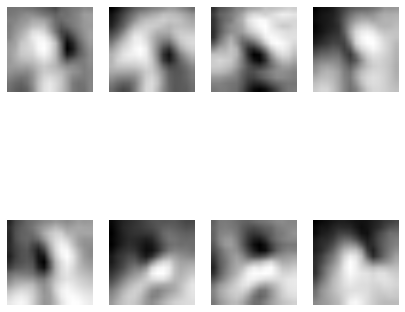

In [7]:
from menpo.image import Image

Image(unified.appearance_models[0].mean().pixels[0, 0]).view()

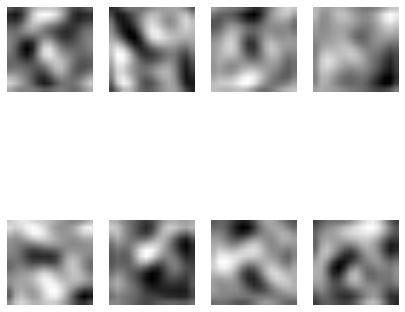

In [8]:
unified.parts_filters()[0][0].view()

### Save

In [15]:
from alabortcvpr2015.utils import pickle_dump

pickle_dump(unified, path + 'PhD/Models/unified_view1_fast_dsift')